In [26]:
#Source: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [27]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir="../keras/grayscale"
data_dir = pathlib.Path(data_dir)

In [28]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

83


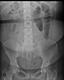

In [29]:
kidneys = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(kidneys[0]))

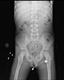

In [30]:
kidneys = list(data_dir.glob('patient/*'))
PIL.Image.open(str(kidneys[1]))

In [31]:
batch_size = 32
img_height = 80
img_width = 64

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83 files belonging to 2 classes.
Using 67 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83 files belonging to 2 classes.
Using 16 files for validation.


In [34]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'patient']


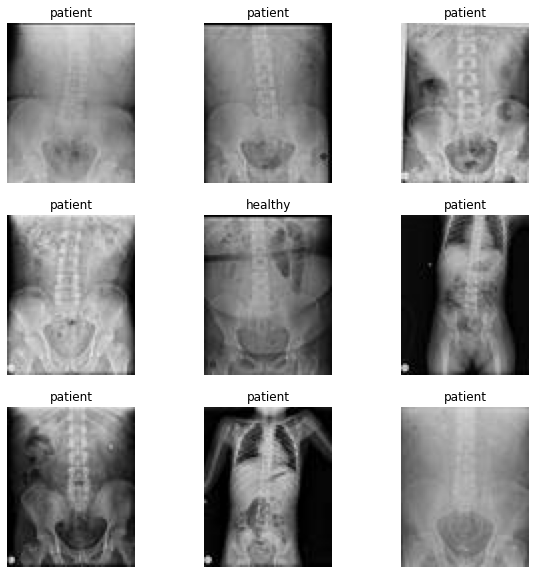

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 64, 3)
(32,)


In [37]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.90196085


In [39]:
#train a model
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [41]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
3/3 [==============================] - 0s 119ms/step - loss: 1.4203 - accuracy: 0.4627 - val_loss: 0.3961 - val_accuracy: 0.9375
Epoch 2/100
3/3 [==============================] - 0s 68ms/step - loss: 0.6825 - accuracy: 0.8507 - val_loss: 0.3721 - val_accuracy: 0.9375
Epoch 3/100
3/3 [==============================] - 0s 72ms/step - loss: 0.7245 - accuracy: 0.8507 - val_loss: 0.2858 - val_accuracy: 0.9375
Epoch 4/100
3/3 [==============================] - 0s 72ms/step - loss: 0.5105 - accuracy: 0.8507 - val_loss: 0.4001 - val_accuracy: 0.9375
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.4911 - accuracy: 0.8507 - val_loss: 0.4241 - val_accuracy: 0.9375
Epoch 6/100
3/3 [==============================] - 0s 67ms/step - loss: 0.4934 - accuracy: 0.8507 - val_loss: 0.3323 - val_accuracy: 0.9375
Epoch 7/100
3/3 [==============================] - 0s 70ms/step - loss: 0.4247 - accuracy: 0.8507 - val_loss: 0.2590 - val_accuracy: 0.9375
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 67ms/step - loss: 0.2850 - accuracy: 0.8657 - val_loss: 0.3061 - val_accuracy: 0.9375
Epoch 60/100
3/3 [==============================] - 0s 65ms/step - loss: 0.3068 - accuracy: 0.8657 - val_loss: 0.2976 - val_accuracy: 0.9375
Epoch 61/100
3/3 [==============================] - 0s 66ms/step - loss: 0.2751 - accuracy: 0.8806 - val_loss: 0.3662 - val_accuracy: 0.9375
Epoch 62/100
3/3 [==============================] - 0s 71ms/step - loss: 0.2809 - accuracy: 0.8806 - val_loss: 0.3455 - val_accuracy: 0.9375
Epoch 63/100
3/3 [==============================] - 0s 80ms/step - loss: 0.2511 - accuracy: 0.8657 - val_loss: 0.3986 - val_accuracy: 0.9375
Epoch 64/100
3/3 [==============================] - 0s 77ms/step - loss: 0.2822 - accuracy: 0.8657 - val_loss: 0.4578 - val_accuracy: 0.9375
Epoch 65/100
3/3 [==============================] - 0s 75ms/step - loss: 0.2849 - accuracy: 0.8657 - val_loss: 0.4656 - val_accuracy: 0.9375
Epoch 66/100
3/3 [========